In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Mixup
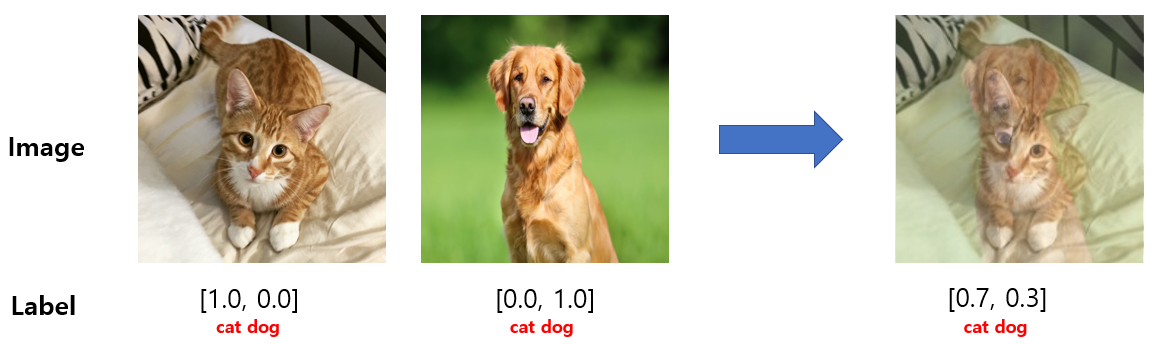

In [2]:
#importing the essential libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import itertools
################
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy import loadtxt
import tensorflow.keras
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import *
%matplotlib inline
from tensorflow import keras
from keras import *
import keras
import cv2
import shutil
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import regularizers
from keras.regularizers import l2
from sklearn.metrics import f1_score, precision_score, recall_score

In [4]:
train_set='/content/drive/MyDrive/kaggledata/Raw_colon/train'
val_set='/content/drive/MyDrive/kaggledata/Raw_colon/val'
test_set='/content/drive/MyDrive/kaggledata/Raw_colon/test'

train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_datagen= image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

# image addressing
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical')
validation_generator = validation_datagen.flow_from_directory(
    val_set,
    target_size = (224,224),
    batch_size = 16,
    shuffle=False,
    class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size = (224,224),
    batch_size = 16,
    shuffle=False,
    class_mode = 'categorical')

Found 3200 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


#mixup_a=0.2

In [ ]:
class MixupImageDataGenerator():
    def __init__(self, generator, directory, batch_size, img_height, img_width, alpha=0.2, subset=None):
        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        self.generator1 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        self.generator2 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Number of classes in image directory.
        self.n = self.generator1.samples

    def reset_index(self):

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):

        return self.n // self.batch_size

    def __next__(self):

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0

        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()

        l = np.random.beta(self.alpha, self.alpha, X1.shape[0])

        X_l = l.reshape(X1.shape[0], 1, 1, 1)
        y_l = l.reshape(X1.shape[0], 1)

        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return X, y
    def __iter__(self):
        while True:
            yield next(self)

#_____________________________________________________________________________________

train_dir = '/content/drive/MyDrive/kaggledata/Raw_colon/train'

batch_size = 16
validation_split = 0.3
img_height = 224
img_width = 224
epochs = 10



# Create training and validation generator.
train_generatormix = MixupImageDataGenerator(generator=train_datagen,
                                          directory=train_dir,
                                          batch_size=batch_size,
                                          img_height=img_height,
                                          img_width=img_width,
                                          subset='training')
#_________________________________________________________________________________

base_model = tf.keras.applications.EfficientNetB2(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=False
model14 = Sequential()
model14.add(base_model)
model14.add(GaussianNoise(0.35))
model14.add(GlobalAveragePooling2D())
model14.add(Dense(256,activation='relu'))
model14.add(BatchNormalization())
model14.add(GaussianNoise(0.35))
model14.add(Dropout(0.2))
model14.add(Dense(4, activation='softmax'))
model14.summary()
model14.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall','AUC'])

checkpoint = ModelCheckpoint("model14.best.keras",monitor="val_accuracy",save_weights_only=True,mode="max",save_best_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 20, min_delta = 0.001,
                              mode='auto',verbose=1)
callbacks2=[checkpoint,reduce_lr]

history14 = model14.fit(
    train_generatormix,
    steps_per_epoch=30, 
    epochs = 50,     
    validation_data = validation_generator,
    callbacks=callbacks2,
)

# Save the training history to a file
import pickle

with open('training_history14.pkl', 'wb') as file:
    pickle.dump(history14.history, file)

Found 3200 images belonging to 4 classes.
Found 3200 images belonging to 4 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 7, 7, 1408)        7768569   
 )                                                               
                                                                 
 gaussian_noise_8 (Gaussian  (None, 7, 7, 1408)        0         
 Noise)                                                          
                                                                 
 global_average_pooling2d_4  (None, 1408)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 256)               360704    
                                                                 
 batch_normalization_4 (Bat  (None, 

In [ ]:
model14.load_weights('model14.best.keras')
model14.evaluate(test_generator)
#loss: 0.1618 - accuracy: 0.9588 - precision: 0.9692 - recall: 0.9438 - auc: 0.9971
#loss: 0.1558 - accuracy: 0.9575 - precision: 0.9654 - recall: 0.9425 - auc: 0.9972
#loss: 0.1588 - accuracy: 0.9563 - precision: 0.9679 - recall: 0.9413 - auc: 0.9976
#acc_Avg : 0.9575
print('-------------------------------------------------------------------')
model14.evaluate(validation_generator)
#loss: 0.1835 - accuracy: 0.9500 - precision: 0.9625 - recall: 0.9360 - auc: 0.9959
#loss: 0.1871 - accuracy: 0.9380 - precision: 0.9521 - recall: 0.9245 - auc: 0.9952
#loss: 0.1838 - accuracy: 0.9435 - precision: 0.9592 - recall: 0.9290 - auc: 0.9961
#acc_Avg : 0.9438
print('-------------------------------------------------------------------')

50/50 [==============================] - 15s 300ms/step - loss: 0.1588 - accuracy: 0.9563 - precision: 0.9679 - recall: 0.9413 - auc: 0.9976
-------------------------------------------------------------------
125/125 [==============================] - 37s 299ms/step - loss: 0.1838 - accuracy: 0.9435 - precision: 0.9592 - recall: 0.9290 - auc: 0.9961
-------------------------------------------------------------------


<ipython-input-5-057dbec3cbaf>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = np.argmax(model14.predict_generator(test_generator), axis=1)


F1 Score for all classes: 0.9439167033524128
Precision for all classes: 0.9453166019093715
Recall for all classes: 0.945
Confusion Matrix : 
 [[200   0   0   0]
 [ 11 167  18   4]
 [  2   9 189   0]
 [  0   0   0 200]]


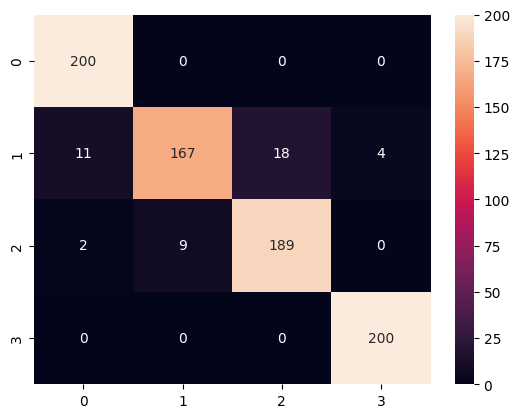

In [ ]:
model14.load_weights('model14.best.keras')
Y_pred = np.argmax(model14.predict_generator(test_generator), axis=1)
Y_test = test_generator.classes
X_test= test_generator

f1 = f1_score(Y_test, Y_pred, average='weighted')
precision = precision_score(Y_test, Y_pred, average='weighted')
recall = recall_score(Y_test, Y_pred, average='weighted')
print("F1 Score for all classes:", f1)
print("Precision for all classes:", precision)
print("Recall for all classes:", recall)

cm1 = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix : \n', cm1)
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True,fmt="d")

#mixup_a=0.3

In [7]:
class MixupImageDataGenerator():
    def __init__(self, generator, directory, batch_size, img_height, img_width, alpha=0.3, subset=None):

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        self.generator1 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        self.generator2 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        self.n = self.generator1.samples

    def reset_index(self):

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):

        return self.n // self.batch_size

    def __next__(self):

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0


        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()

        l = np.random.beta(self.alpha, self.alpha, X1.shape[0])

        X_l = l.reshape(X1.shape[0], 1, 1, 1)
        y_l = l.reshape(X1.shape[0], 1)

        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return X, y
    def __iter__(self):
        while True:
            yield next(self)

#_____________________________________________________________________________________

train_dir = '/content/drive/MyDrive/kaggledata/Raw_colon/train'

batch_size = 16
validation_split = 0.3
img_height = 224
img_width = 224
epochs = 10

# Create training and validation generator.
train_generatormix = MixupImageDataGenerator(generator=train_datagen,
                                          directory=train_dir,
                                          batch_size=batch_size,
                                          img_height=img_height,
                                          img_width=img_width,
                                          subset='training')
#_________________________________________________________________________________

base_model = tf.keras.applications.EfficientNetB2(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=False
model15 = Sequential()
model15.add(base_model)
model15.add(GaussianNoise(0.35))
model15.add(GlobalAveragePooling2D())
model15.add(Dense(256,activation='relu'))
model15.add(BatchNormalization())
model15.add(GaussianNoise(0.35))
model15.add(Dropout(0.2))
model15.add(Dense(4, activation='softmax'))
model15.summary()
model15.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall','AUC'])

checkpoint = ModelCheckpoint("model15.best.keras",monitor="val_accuracy",save_weights_only=True,mode="max",save_best_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 20, min_delta = 0.001,
                              mode='auto',verbose=1)
callbacks2=[checkpoint,reduce_lr]

history15 = model15.fit(
    train_generatormix,
    steps_per_epoch=30, 
    epochs = 50,     
    validation_data = validation_generator,
    callbacks=callbacks2,
)

# Save the training history to a file
import pickle

with open('training_history15.pkl', 'wb') as file:
    pickle.dump(history15.history, file)

Found 3200 images belonging to 4 classes.
Found 3200 images belonging to 4 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 7, 7, 1408)        7768569   
 )                                                               
                                                                 
 gaussian_noise_2 (Gaussian  (None, 7, 7, 1408)        0         
 Noise)                                                          
                                                                 
 global_average_pooling2d_1  (None, 1408)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               360704    
                                                                 
 batch_normalization_1 (Bat  (None, 

In [8]:
model15.load_weights('model15.best.keras')
model15.evaluate(test_generator)
#loss: 0.1822 - accuracy: 0.9488 - precision: 0.9675 - recall: 0.9300 - auc: 0.9971
#loss: 0.1791 - accuracy: 0.9538 - precision: 0.9690 - recall: 0.9388 - auc: 0.9961
#loss: 0.1667 - accuracy: 0.9575 - precision: 0.9679 - recall: 0.9425 - auc: 0.9977
#acc_Avg : 0.9533
print('-------------------------------------------------------------------')
model15.evaluate(validation_generator)
#loss: 0.2113 - accuracy: 0.9395 - precision: 0.9601 - recall: 0.9155 - auc: 0.9944
#loss: 0.1930 - accuracy: 0.9530 - precision: 0.9657 - recall: 0.9305 - auc: 0.9956
#loss: 0.1869 - accuracy: 0.9455 - precision: 0.9589 - recall: 0.9340 - auc: 0.9960
#acc_Avg : 0.9460
print('-------------------------------------------------------------------')

50/50 [==============================] - 19s 372ms/step - loss: 0.1667 - accuracy: 0.9575 - precision: 0.9679 - recall: 0.9425 - auc: 0.9977
-------------------------------------------------------------------
125/125 [==============================] - 48s 387ms/step - loss: 0.1869 - accuracy: 0.9455 - precision: 0.9589 - recall: 0.9340 - auc: 0.9960
-------------------------------------------------------------------


<ipython-input-8-4ca30f687f51>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = np.argmax(model15.predict_generator(test_generator), axis=1)


F1 Score for all classes: 0.9446055035503386
Precision for all classes: 0.9453697154612487
Recall for all classes: 0.945
Confusion Matrix : 
 [[200   0   0   0]
 [  3 174  21   2]
 [  6  10 184   0]
 [  0   0   2 198]]


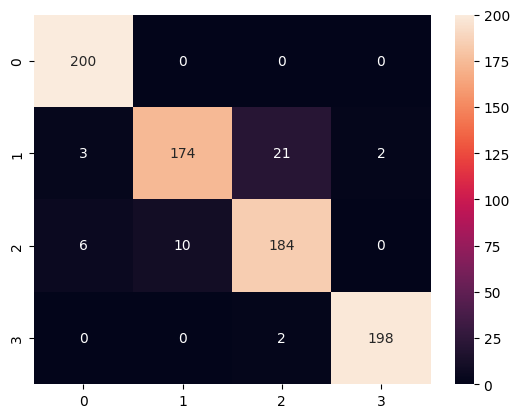

In [ ]:
model15.load_weights('model15.best.keras')
Y_pred = np.argmax(model15.predict_generator(test_generator), axis=1)
Y_test = test_generator.classes
X_test= test_generator

f1 = f1_score(Y_test, Y_pred, average='weighted')
precision = precision_score(Y_test, Y_pred, average='weighted')
recall = recall_score(Y_test, Y_pred, average='weighted')
print("F1 Score for all classes:", f1)
print("Precision for all classes:", precision)
print("Recall for all classes:", recall)

cm1 = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix : \n', cm1)
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True,fmt="d")

#mixup_a=0.4

In [9]:
class MixupImageDataGenerator():
    def __init__(self, generator, directory, batch_size, img_height, img_width, alpha=0.4, subset=None):

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        self.generator1 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        self.generator2 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        self.n = self.generator1.samples

    def reset_index(self):

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):

        return self.n // self.batch_size

    def __next__(self):

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0


        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()

        l = np.random.beta(self.alpha, self.alpha, X1.shape[0])

        X_l = l.reshape(X1.shape[0], 1, 1, 1)
        y_l = l.reshape(X1.shape[0], 1)

        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return X, y
    def __iter__(self):
        while True:
            yield next(self)

#_____________________________________________________________________________________

train_dir = '/content/drive/MyDrive/kaggledata/Raw_colon/train'

batch_size = 16
validation_split = 0.3
img_height = 224
img_width = 224
epochs = 10

# Create training and validation generator.
train_generatormix = MixupImageDataGenerator(generator=train_datagen,
                                          directory=train_dir,
                                          batch_size=batch_size,
                                          img_height=img_height,
                                          img_width=img_width,
                                          subset='training')
#_________________________________________________________________________________

base_model = tf.keras.applications.EfficientNetB2(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=False
model16 = Sequential()
model16.add(base_model)
model16.add(GaussianNoise(0.35))
model16.add(GlobalAveragePooling2D())
model16.add(Dense(256,activation='relu'))
model16.add(BatchNormalization())
model16.add(GaussianNoise(0.35))
model16.add(Dropout(0.2))
model16.add(Dense(4, activation='softmax'))
model16.summary()
model16.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall','AUC'])

checkpoint = ModelCheckpoint("model16.best.keras",monitor="val_accuracy",save_weights_only=True,mode="max",save_best_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 20, min_delta = 0.001,
                              mode='auto',verbose=1)
callbacks2=[checkpoint,reduce_lr]

history16 = model16.fit(
    train_generatormix,
    steps_per_epoch=30, 
    epochs = 50,    
    validation_data = validation_generator,
    callbacks=callbacks2,
)

import pickle

with open('training_history16.pkl', 'wb') as file:
    pickle.dump(history16.history, file)

Found 3200 images belonging to 4 classes.
Found 3200 images belonging to 4 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 7, 7, 1408)        7768569   
 )                                                               
                                                                 
 gaussian_noise_4 (Gaussian  (None, 7, 7, 1408)        0         
 Noise)                                                          
                                                                 
 global_average_pooling2d_2  (None, 1408)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               360704    
                                                                 
 batch_normalization_2 (Bat  (None, 

In [10]:
model16.load_weights('model16.best.keras')
model16.evaluate(test_generator)
#loss: 0.1858 - accuracy: 0.9600 - precision: 0.9702 - recall: 0.9362 - auc: 0.9965
#loss: 0.2026 - accuracy: 0.9500 - precision: 0.9687 - recall: 0.9287 - auc: 0.9963
#loss: 0.1755 - accuracy: 0.9600 - precision: 0.9643 - recall: 0.9463 - auc: 0.9960
#acc_Avg : 0.9566
print('-------------------------------------------------------------------')
model16.evaluate(validation_generator)
#loss: 0.2117 - accuracy: 0.9415 - precision: 0.9584 - recall: 0.9220 - auc: 0.9947
#loss: 0.2243 - accuracy: 0.9400 - precision: 0.9621 - recall: 0.9135 - auc: 0.9940
#loss: 0.1977 - accuracy: 0.9420 - precision: 0.9591 - recall: 0.9255 - auc: 0.9949
#acc_Avg : 0.9411
print('-------------------------------------------------------------------')

50/50 [==============================] - 18s 366ms/step - loss: 0.1755 - accuracy: 0.9600 - precision: 0.9643 - recall: 0.9463 - auc: 0.9960
-------------------------------------------------------------------
125/125 [==============================] - 47s 379ms/step - loss: 0.1977 - accuracy: 0.9420 - precision: 0.9591 - recall: 0.9255 - auc: 0.9949
-------------------------------------------------------------------


<ipython-input-11-abda69aab659>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = np.argmax(model16.predict_generator(test_generator), axis=1)


F1 Score for all classes: 0.9521087813363474
Precision for all classes: 0.9525111773491122
Recall for all classes: 0.9525
Confusion Matrix : 
 [[200   0   0   0]
 [  5 184   9   2]
 [  6  15 179   0]
 [  0   1   0 199]]


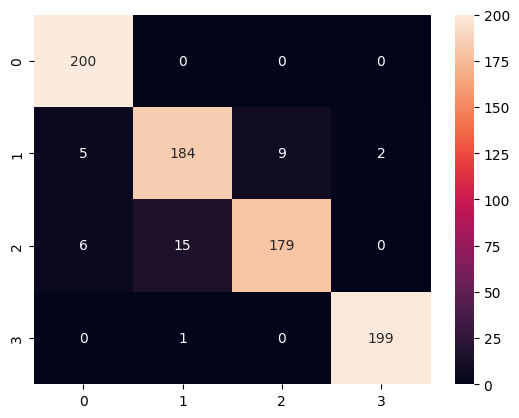

In [ ]:
model16.load_weights('model16.best.keras')
Y_pred = np.argmax(model16.predict_generator(test_generator), axis=1)
Y_test = test_generator.classes
X_test= test_generator

f1 = f1_score(Y_test, Y_pred, average='weighted')
precision = precision_score(Y_test, Y_pred, average='weighted')
recall = recall_score(Y_test, Y_pred, average='weighted')
print("F1 Score for all classes:", f1)
print("Precision for all classes:", precision)
print("Recall for all classes:", recall)

cm1 = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix : \n', cm1)
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True,fmt="d")

#mixup_a=0.5

In [5]:
class MixupImageDataGenerator():
    def __init__(self, generator, directory, batch_size, img_height, img_width, alpha=0.5, subset=None)

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        self.generator1 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        self.generator2 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        self.n = self.generator1.samples

    def reset_index(self):

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):


        return self.n // self.batch_size

    def __next__(self):


        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0


        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()


        l = np.random.beta(self.alpha, self.alpha, X1.shape[0])

        X_l = l.reshape(X1.shape[0], 1, 1, 1)
        y_l = l.reshape(X1.shape[0], 1)


        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return X, y
    def __iter__(self):
        while True:
            yield next(self)

#_____________________________________________________________________________________

train_dir = '/content/drive/MyDrive/kaggledata/Raw_colon/train'

batch_size = 16
validation_split = 0.3
img_height = 224
img_width = 224
epochs = 10



# Create training and validation generator.
train_generatormix = MixupImageDataGenerator(generator=train_datagen,
                                          directory=train_dir,
                                          batch_size=batch_size,
                                          img_height=img_height,
                                          img_width=img_width,
                                          subset='training')
#_________________________________________________________________________________

base_model = tf.keras.applications.EfficientNetB2(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=False
model17 = Sequential()
model17.add(base_model)
model17.add(GaussianNoise(0.35))
model17.add(GlobalAveragePooling2D())
model17.add(Dense(256,activation='relu'))
model17.add(BatchNormalization())
model17.add(GaussianNoise(0.35))
model17.add(Dropout(0.2))
model17.add(Dense(4, activation='softmax'))
model17.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall','AUC'])

checkpoint = ModelCheckpoint("model17.best.keras",monitor="val_accuracy",save_weights_only=True,mode="max",save_best_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 20, min_delta = 0.001,
                              mode='auto',verbose=1)
callbacks2=[checkpoint,reduce_lr]

history17 = model17.fit(
    train_generatormix,
    steps_per_epoch=30, 
    epochs = 50,     
    validation_data = validation_generator,
    callbacks=callbacks2,
)

import pickle

with open('training_history17.pkl', 'wb') as file:
    pickle.dump(history17.history, file)

Found 3200 images belonging to 4 classes.
Found 3200 images belonging to 4 classes.
31790344/31790344 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 7, 7, 1408)        7768569   
 )                                                               
                                                                 
 gaussian_noise (GaussianNo  (None, 7, 7, 1408)        0         
 ise)                                                            
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               360704    
                                       

In [11]:
model17.load_weights('model17.best.keras')
model17.evaluate(test_generator)
#loss: 0.1973 - accuracy: 0.9450 - precision: 0.9637 - recall: 0.9300 - auc: 0.9961
#loss: 0.2394 - accuracy: 0.9375 - precision: 0.9593 - recall: 0.9125 - auc: 0.9953
#loss: 0.2255 - accuracy: 0.9500 - precision: 0.9696 - recall: 0.9162 - auc: 0.9965
#acc_Avg : 0.9441
print('-------------------------------------------------------------------')
model17.evaluate(validation_generator)
#loss: 0.2209 - accuracy: 0.9415 - precision: 0.9633 - recall: 0.9180 - auc: 0.9944
#loss: 0.2511 - accuracy: 0.9355 - precision: 0.9588 - recall: 0.9085 - auc: 0.9942
#loss: 0.2406 - accuracy: 0.9440 - precision: 0.9632 - recall: 0.9155 - auc: 0.9953
#acc_Avg : 0.9403
print('-------------------------------------------------------------------')

50/50 [==============================] - 19s 387ms/step - loss: 0.2255 - accuracy: 0.9500 - precision: 0.9696 - recall: 0.9162 - auc: 0.9965
-------------------------------------------------------------------
125/125 [==============================] - 49s 390ms/step - loss: 0.2406 - accuracy: 0.9440 - precision: 0.9632 - recall: 0.9155 - auc: 0.9953
-------------------------------------------------------------------


<ipython-input-14-bbb4f156fc84>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = np.argmax(model17.predict_generator(test_generator), axis=1)


F1 Score for all classes: 0.9478984644938165
Precision for all classes: 0.9493064347760969
Recall for all classes: 0.94875
Confusion Matrix : 
 [[200   0   0   0]
 [  5 171  17   7]
 [  6   6 188   0]
 [  0   0   0 200]]


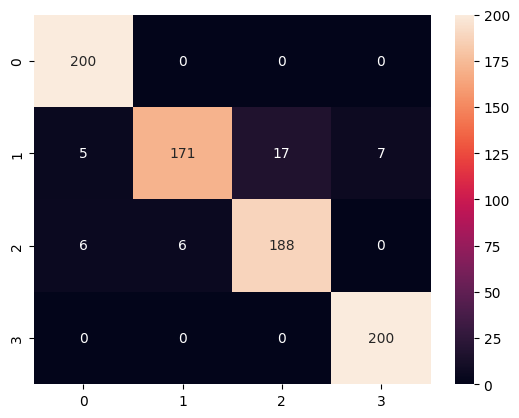

In [ ]:
model17.load_weights('model17.best.keras')
Y_pred = np.argmax(model17.predict_generator(test_generator), axis=1)
Y_test = test_generator.classes
X_test= test_generator

f1 = f1_score(Y_test, Y_pred, average='weighted')
precision = precision_score(Y_test, Y_pred, average='weighted')
recall = recall_score(Y_test, Y_pred, average='weighted')
print("F1 Score for all classes:", f1)
print("Precision for all classes:", precision)
print("Recall for all classes:", recall)

cm1 = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix : \n', cm1)
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True,fmt="d")

#=> So the best alpha for mixup is : 0.2